#Analysis of classifiers

In this part of the code a connection is made between github and this file.
All the documents from github are imported, inluding our data.
The files that are not needed for our assignment were deleted from github.

In [1]:
!pip install -q --upgrade git+https://github.com/NFAFrijns/TM10007_G1_lipo.git

  Preparing metadata (setup.py) ... done


Original shape:  (115, 492)
PCA80 shape:  (115, 18)
PCA90 shape:  (115, 34)
PCA95 shape:  (115, 49)


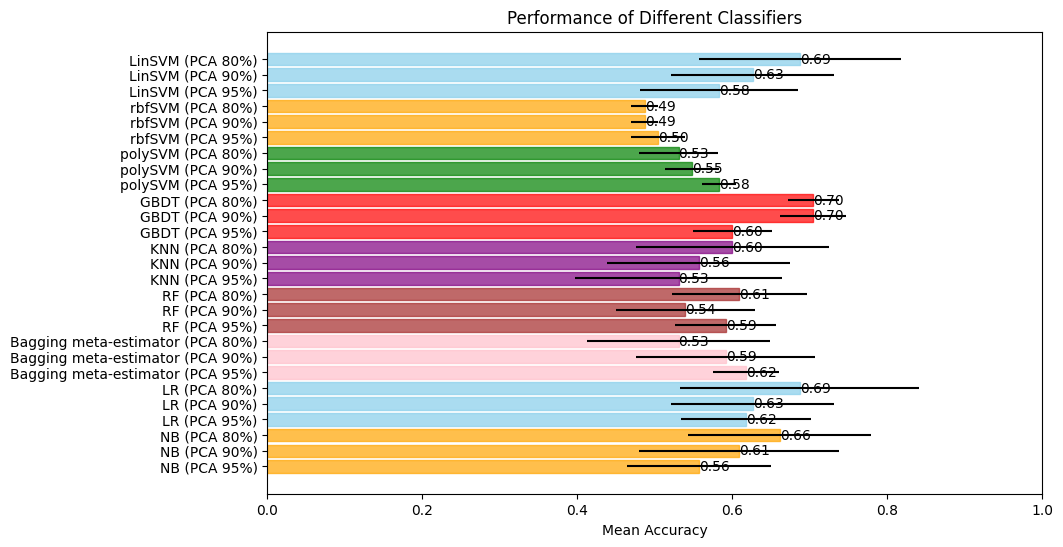

In [21]:
import pandas as pd
from worclipo.load_data import load_data
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

#Inladen data
feature_data = load_data()
X_train = feature_data.iloc[:, 2:]
y_train = feature_data['label']

#Feature selection
numb_components = 70     # number of components
x_scaled = StandardScaler().fit_transform(X_train) #DATA SCALING: voor nu even heel simple scaling, wachten op wat Nico doet voor echte voorbewerking
pca = PCA(n_components=numb_components) # Reduce from 4 to 3 features with PCA
pca_features = pca.fit_transform(x_scaled) # Fit and transform data
print('Original shape: ', x_scaled.shape) # Remake X_train with less components

# 80% explained variance
pca80 = PCA(n_components=0.80)
X_train_PCA80 = pca80.fit_transform(x_scaled)
print('PCA80 shape: ', X_train_PCA80.shape)

# 90% explained variance
pca90 = PCA(n_components=0.90)
X_train_PCA90 = pca90.fit_transform(x_scaled)
print('PCA90 shape: ', X_train_PCA90.shape)

# 95% explained variance
pca95 = PCA(n_components=0.95)
X_train_PCA95 = pca95.fit_transform(x_scaled)
print('PCA95 shape: ', X_train_PCA95.shape)

classifiers = [
    (svm.SVC(kernel='linear', C=1.0, random_state=42), "LinSVM"),
    (svm.SVC(kernel="rbf", gamma=0.7, C=1.0), "rbfSVM"),
    (svm.SVC(kernel="poly", degree=2, gamma="auto", C=1.0), "polySVM"),
    (HistGradientBoostingClassifier(max_iter=100), "GBDT"),
    (KNeighborsClassifier(n_neighbors=5), "KNN"),
    (ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0), "RF"),
    (BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5), "Bagging meta-estimator"),
    (LogisticRegression(random_state=1), "LR"),
    (GaussianNB(), "NB")
]

results = {}
for clf, label in classifiers:
    # Scores berekenen voor PCA80
    scores_PCA80 = cross_val_score(clf, X_train_PCA80, y_train, cv=5)
    mean_accuracy_PCA80 = scores_PCA80.mean()
    std_dev_PCA80 = scores_PCA80.std()

    # Scores berekenen voor PCA90
    scores_PCA90 = cross_val_score(clf, X_train_PCA90, y_train, cv=5)
    mean_accuracy_PCA90 = scores_PCA90.mean()
    std_dev_PCA90 = scores_PCA90.std()

    # Scores berekenen voor PCA95
    scores_PCA95 = cross_val_score(clf, X_train_PCA95, y_train, cv=5)
    mean_accuracy_PCA95 = scores_PCA95.mean()
    std_dev_PCA95 = scores_PCA95.std()

    # Opslaan van resultaten
    results[label + ' (PCA 80%)'] = (mean_accuracy_PCA80, std_dev_PCA80)
    results[label + ' (PCA 90%)'] = (mean_accuracy_PCA90, std_dev_PCA90)
    results[label + ' (PCA 95%)'] = (mean_accuracy_PCA95, std_dev_PCA95)

# Plot resultaten
labels = list(results.keys())
mean_accuracies = [result[0] for result in results.values()]
std_devs = [result[1] for result in results.values()]
colors = ['skyblue', 'skyblue', 'skyblue', 'orange', 'orange', 'orange', 'green', 'green', 'green', 'red', 'red', 'red', 'purple', 'purple', 'purple', 'brown', 'brown', 'brown', 'pink', 'pink', 'pink']

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, mean_accuracies, xerr=std_devs, edgecolor='black', alpha=0.7)

# Loop door elke balk en pas de kleur aan op basis van de index van de classifier in de lijst
for i, bar in enumerate(bars):
    bar.set_color(colors[i % len(colors)])  # Gebruik modulo om ervoor te zorgen dat kleuren worden hergebruikt indien nodig
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{mean_accuracies[i]:.2f}', va='center')

plt.xlabel('Mean Accuracy')
plt.title('Performance of Different Classifiers')
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.show()

